In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
np.random.seed(42)


ROOT_DIR = Path(os.getcwd()).parent.parent

<h4>Load computed features</h4>

In [2]:
df: pd.DataFrame = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_26_06.parquet")
)

df = df.reset_index(drop=True)
# Create pump hash and convert pump time to datetime
df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["pump_time"] = pd.to_datetime(df["pump_time"])

df.head(1)

,overall_return_1h,volume_quote_abs_zscore_1h_30d,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,overall_return_24h,volume_quote_abs_zscore_24h_30d,...,quote_abs_powerlaw_alpha_48h,quote_abs_powerlaw_alpha_72h,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
0,0.997007,0.933374,0.510101,1.362662,4.040168,0.499154,0.576093,1.1805,1.263992,0.561464,...,0.308556,0.303744,0,binance,PPTBTC,2018-01-03 18:00:00,MANABTC,False,40,PPTBTC_2018-01-03 18:00:00


<h4>Add 1 minute return after the pump annoucement as the target to be ranked by</h4>

In [3]:
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class Ticker:
    ticker: str
    time: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Ticker: {self.ticker} - {str(self.time)}"
    
@dataclass
class PumpEvent(Ticker):
    ticker: str
    time: str
    

# load trade data for a given ticker
def load_data(
    ticker: Ticker, lookback_delta: timedelta, 
    forward_delta: timedelta
) -> pd.DataFrame:

    end: pd.Timestamp = ticker.time + forward_delta
    start: pd.Timestamp = ticker.time - lookback_delta

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start, end=end, freq="D", inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{ticker.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker.ticker}", file_name)
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    df["quote_abs"] = df["price"] * df["qty"] # calculate quote spent

    return df

In [4]:
def compute_return(ticker: Ticker) -> float:
    """Calculates return of the ticker around some pump.time"""

    df_asset: pd.DataFrame = load_data(
        ticker=ticker, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
    )

    df_asset: pd.DataFrame = df_asset[
        (df_asset["time"] >= ticker.time - timedelta(minutes=1)) &
        (df_asset["time"] <= ticker.time + timedelta(minutes=1))
    ].copy()

    if df_asset.empty:
        return 0

    start_price, end_price = df_asset["price"].iloc[0], df_asset["price"].iloc[-1]
    asset_return: float = (end_price - start_price) / start_price

    return asset_return

In [5]:
df_returns: pd.DataFrame = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in tqdm(df.groupby(["pumped_ticker", "pump_time"])):

    tickers_crosssection: List[str] = df_pump["ticker"].tolist()
    asset_returns: List[float] = []

    for ticker in tickers_crosssection:
        ticker_obj: Ticker = Ticker(ticker=ticker, time=pump_time)
        asset_returns.append(
            compute_return(ticker=ticker_obj)
        )
    
    df_pump["asset_return"] = asset_returns
    df_returns = pd.concat([df_returns, df_pump])

100%|██████████| 353/353 [07:13<00:00,  1.23s/it]


In [6]:
df_returns = df_returns.replace([np.inf, -np.inf], np.nan)

df_returns.isna().sum().sort_values(ascending=False).head(10)

quote_slippage_imbalance_ratio_1h     3918
quote_slippage_imbalance_ratio_6h      582
log_return_std_6h_30d                  354
quote_slippage_imbalance_ratio_24h     103
log_return_zscore_6h_30d                85
quote_slippage_imbalance_ratio_48h      24
quote_slippage_imbalance_ratio_72h       9
log_return_std_24h_30d                   5
overall_return_1h                        0
quote_abs_powerlaw_alpha_1h              0
dtype: int64

In [7]:
num_cols: List[str] = df_returns.columns[:-9].tolist() + ["days_listed"]
cat_cols: List[str] = ["num_prev_pumps"]

reg_cols: List[str] = num_cols + cat_cols


df_returns[cat_cols] = df_returns[cat_cols].astype("category")

In [8]:
powerlaw_cols: List[str] = [col for col in df_returns.columns if "powerlaw" in col]

df_returns: pd.DataFrame = df_returns[(df_returns[powerlaw_cols] < 10).all(axis=1)].copy()

In [9]:
# skip pump if any variable is missing
df_pumps = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df_returns.groupby("pump_hash")):
    # if any feature is missing for the pump observation, then there is no point to fill it with median value
    if any(df_pump[df_pump["is_pumped"]].isna().any()):
        continue
    # otherwise fill other cols with median
    for col in num_cols:
        col_median: float = df_pump[col].median()
        df_pump[col] = df_pump[col].fillna(col_median)

    df_pump["pump_id"] = i

    df_pumps = pd.concat([df_pumps, df_pump])

In [10]:
# sort pumps by time
df_pumps = df_pumps.sort_values(by="pump_time", ascending=True).reset_index(drop=True)

# assign return rank
df_pumps["asset_return_rank"] = df_pumps.groupby("pump_id")["asset_return"].rank(method="first", ascending=False).astype(int)

In [11]:
cols_to_scale: List[str] = [
    col for col in df_pumps.columns if (
        ("overall_return" in col) or ("quote_abs_powerlaw" in col)  or ("zscore" in col)
    )
]

# Apply cross-sectional standardization
df_scaled: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_pumps.groupby("pump_hash")):
    # Scale each pump by its crosssection
    for col in cols_to_scale:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled = pd.concat([df_scaled, df_pump])

df_scaled.head(2)

100%|██████████| 340/340 [00:02<00:00, 149.87it/s]


,overall_return_1h,volume_quote_abs_zscore_1h_30d,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,overall_return_24h,volume_quote_abs_zscore_24h_30d,...,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash,asset_return,pump_id,asset_return_rank
10526,-0.103819,-0.191118,0.696173,-0.432901,-0.333821,0.363357,-0.306877,-0.416140,-0.712935,-0.312135,...,binance,ADXBTC,2019-07-05 17:00:00,MITHBTC,False,232,ADXBTC_2019-07-05 17:00:00,0.000000,0,16
10527,-0.445964,-0.350223,0.681522,0.409580,-0.557123,0.423294,-0.375690,0.446235,-0.912100,-0.352185,...,binance,ADXBTC,2019-07-05 17:00:00,VIBBTC,False,613,ADXBTC_2019-07-05 17:00:00,-0.004988,0,83


In [12]:
df_scaled[df_scaled["is_pumped"]]["asset_return_rank"].value_counts().to_frame()

,count
asset_return_rank,
1,292
2,21
3,7
4,3
5,2
220,1
139,1
127,1
231,1


In [13]:
df_scaled["asset_return_inv_pct_rank"] = df_scaled.groupby("pump_id")["asset_return"].rank(pct=True, ascending=True)

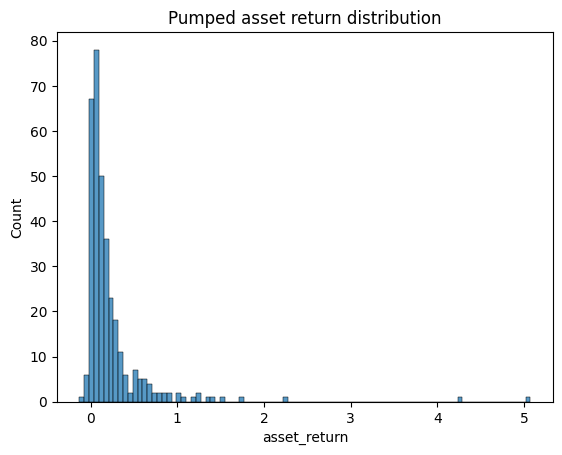

In [14]:
sns.histplot(
    data=df_scaled[df_scaled["is_pumped"]], x="asset_return",
)
plt.title("Pumped asset return distribution")
plt.show()

In [15]:
df_train, df_test = (
    df_scaled[df_scaled["pump_time"] <= "2021-01-01"].copy(), # train sample
    df_scaled[df_scaled["pump_time"] > "2021-01-01"].copy() # test sample
)

df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [16]:
df_train["is_pumped"].value_counts(), df_test["is_pumped"].value_counts()

(is_pumped
 False    28663
 True       288
 Name: count, dtype: int64,
 is_pumped
 False    9484
 True       52
 Name: count, dtype: int64)

<h4>Remove failed pumps from train sample (where pumped asset is not ranked first in terms of returns)</h4>

In [17]:
df_filtered_train: pd.DataFrame = pd.DataFrame()

for pump_id, df_pump in df_train.groupby("pump_id"):
    if df_pump[df_pump["is_pumped"]]["asset_return_rank"].iloc[0] == 1:
        df_filtered_train = pd.concat([df_filtered_train, df_pump])

df_filtered_train["is_pumped"].value_counts()

is_pumped
False    24508
True       247
Name: count, dtype: int64

<h4>Train CatboostRanker</h4>

In [18]:
from catboost import CatBoostRanker, Pool

In [19]:
class KFoldCrosssection:

    def __init__(self, n_splits: int) -> Self:
        self.n_splits: int = n_splits

    def split(self, df: pd.DataFrame) -> Iterable[Union[pd.DataFrame, pd.DataFrame]]:
        """Split dataframe into K contiguous splits taking into account cross-sectional structure of the data"""
        bins: np.array = np.linspace(
            df["pump_id"].min(), df["pump_id"].max(), self.n_splits
        )

        for i in range(1, len(bins)):
            val_fold: pd.Series = (df["pump_id"] >= bins[i-1]) & (df["pump_id"] < bins[i]) # splits based on pump_ids
            train, val = df[~val_fold].copy(), df[val_fold].copy()

            yield train, val

In [20]:
# TOPK AUC
from sklearn.metrics import auc

def calculate_topk_percent(df: pd.DataFrame, relevance_scores: np.array, topk_share_bins: np.array):

    dfc: pd.DataFrame = df.copy()
    # Rank assets by relevance score
    dfc["relevance_score"] = relevance_scores
    dfc["predicted_rank"] = dfc.groupby("pump_id")["relevance_score"].rank(ascending=False)

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_id"):
        df_pump: pd.DataFrame = df_pump.sort_values(by="predicted_rank", ascending=False) # sort tickers by their predicted rank 
        
        # calculate percentages 
        df_pump = df_pump.reset_index(drop=True) # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio["is_pumped"].any() # see if any of the top k% rankings are pumps
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}


def calculate_topk_percent_auc(
    df: pd.DataFrame, relevance_scores: np.array, topk_share_bins: np.array
) -> float:
    """Calculates Area under TOP-K% curve"""
    topk: Dict[float, float] = calculate_topk_percent(
        df=df, relevance_scores=relevance_scores, topk_share_bins=topk_share_bins
    )
    topk_vals: List[float] = list(topk.values())
    return auc(x=topk_share_bins, y=topk_vals)

In [24]:
from optuna.trial import Trial
from functools import partial
from catboost.utils import eval_metric

import optuna


def objective_cb_ranking(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str],
    fold: KFoldCrosssection
) -> Tuple[float, float]:

    train: pd.DataFrame
    val: pd.DataFrame

    cb_params = dict(
        iterations=trial.suggest_int("iterations", 10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
        max_depth=trial.suggest_int("max_depth", 2, 5),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.7, 1),
        # Non-tunable params
        objective="YetiRank:mode=NDCG",
        border_count=255,
        verbose=False,
    )

    topk_auc_scores: List[float] = []

    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    for train, val in fold.split(df_train):
        
        model = CatBoostRanker(**cb_params)

        ptrain: Pool = Pool(
            data=train[reg_cols], cat_features=cat_cols,
            label=train["asset_return_inv_pct_rank"],
            group_id=train["pump_id"]
        )

        pval: Pool = Pool(
            data=val[reg_cols], cat_features=cat_cols,
            label=val["asset_return_inv_pct_rank"],
            group_id=val["pump_id"]
        )

        model = model.fit(ptrain)
        # Predict rankings on validation sample
        relevance_scores: np.array = model.predict(pval)

        topk_auc_scores.append(
            calculate_topk_percent_auc(df=val, relevance_scores=relevance_scores, topk_share_bins=X)
        )
        
    return np.mean(topk_auc_scores)

In [ ]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_ranking = optuna.create_study(
    direction="maximize"
)

study_ranking.optimize(
    partial(objective_cb_ranking, df_train=df_filtered_train, reg_cols=reg_cols, fold=fold), 
    n_trials=25
)

In [33]:
ptrain: Pool = Pool(
    data=df_filtered_train[reg_cols], cat_features=cat_cols,
    label=df_filtered_train["asset_return_inv_pct_rank"],
    group_id=df_filtered_train["pump_id"]
)

ptest: Pool = Pool(
    data=df_test[reg_cols], cat_features=cat_cols,
    group_id=df_test["pump_id"]
)

model_cb_params = dict(
    objective="YetiRank:mode=NDCG",
    border_count=255,
    verbose=False
)

model_cb_params.update(study_ranking.best_params)

In [34]:
model_cb_params

{'objective': 'YetiRank:mode=NDCG',
 'border_count': 255,
 'verbose': False,
 'iterations': 108,
 'learning_rate': 0.04522180346046348,
 'max_depth': 2,
 'colsample_bylevel': 0.8542113013716364}

In [35]:
cb_ranker = CatBoostRanker(
    **model_cb_params
)
cb_ranker = cb_ranker.fit(ptrain)

In [36]:
relevance_scores: np.array = cb_ranker.predict(ptrain)

df_filtered_train["relevance_score"] = relevance_scores
df_filtered_train["predicted_rank"] = df_filtered_train.groupby("pump_id")["relevance_score"].rank(ascending=True)

topk_bins: List[int] = [1, 3, 5, 10, 20, 30, 50]
num_pumps_train: int = df_filtered_train["is_pumped"].sum()

topk_scores: List[float] = []

for K in topk_bins:
    num_caught_pumps: int = df_filtered_train[df_filtered_train["is_pumped"] & (df_filtered_train["predicted_rank"] <= K)].shape[0]

    topk_scores.append(
        # topk-recall 
        num_caught_pumps / num_pumps_train
    )

pd.DataFrame({
    "K": topk_bins,
    "TOPK": topk_scores
})

,K,TOPK
0,1,0.020243
1,3,0.048583
2,5,0.080972
3,10,0.121457
4,20,0.246964
5,30,0.388664
6,50,0.623482
